# Edgar Sabán - 19012631

# Lab3

## Parte 1


In [19]:
import tensorflow.compat.v1 as tf
from tensorflow import keras
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from random import sample 

%reload_ext tensorboard

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

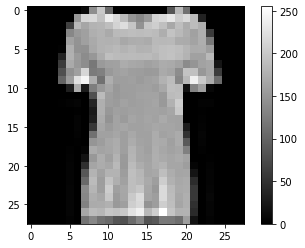

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

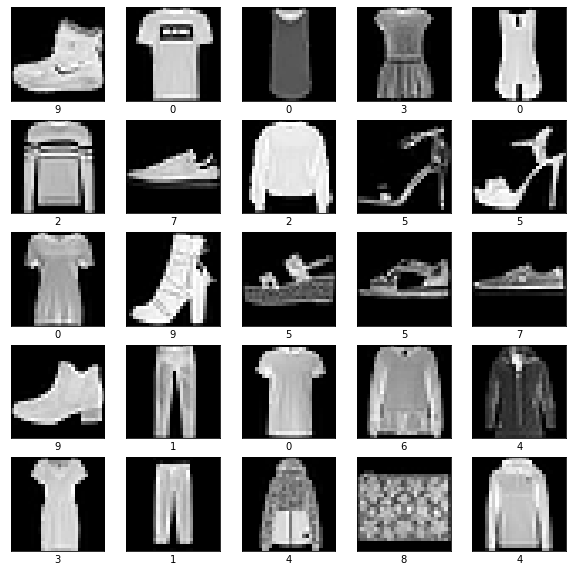

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Instrucciones

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Preparación de los datos

In [7]:
# Diccionario de labels
diccionarioLabels =  {0:"T-shirt/top", 1: "Trouser",
                      2: "Pullover", 3: "Dress",
                      4: "Coat", 5: "Sandal",
                      6: "Shirt", 7: "Sneaker",
                      8: "Bag", 9: "Ankle boot"}

# Aplicando One hot encode a los datos de entrenamiento
ohe_train = OneHotEncoder(categories='auto')
ohe_train.fit(train_labels.reshape(-1, 1))
ohe_labels_train = ohe_train.transform(train_labels.reshape(-1,1)).toarray()

# Aplicando One hot encode a los datos de prueba
ohe_test = OneHotEncoder(categories='auto')
ohe_test.fit(test_labels.reshape(-1, 1))
ohe_labels_test = ohe_test.transform(test_labels.reshape(-1,1)).toarray()

In [8]:
# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeRaw(imgs):
    # Definiendo el nuevo shape
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    # Agregando un 1 para complementar el tensor y que sirva para los cálculos
    # más adelante
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeNormalized(imgs):
    # Definiendo el nuevo shape
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    # Normalizando el vector
    imgs_shaped = normalize(imgs_shaped, norm = 'max', axis = 1)
    # Agregando un 1 para complementar el tensor y que sirva para los cálculos
    # más adelante
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeScaled(imgs):
    # Definiendo el nuevo shape
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    # Escalando images
    imgs_shaped = scale(imgs_shaped)
    # Agregando un 1 para complementar el tensor y que sirva para los cálculos
    # más adelante
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

In [9]:
# X listos para usar en el modelo de regresión logística
xtrain_raw = toTensorShapeRaw(train_images)
xtest_raw = toTensorShapeRaw(test_images)
xtrain_nor = toTensorShapeNormalized(train_images)
xtest_nor = toTensorShapeNormalized(test_images)
xtrain_sca = toTensorShapeNormalized(train_images)
xtest_sca = toTensorShapeNormalized(test_images)

## Modelo de regresión logística con Tensor Flow

In [10]:
# MRL = modelo de regresión logística
class MRL:
    # Constructor de clase para la inicialización de los parámetros
    def __init__(self, x, labels):
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, 
                                          shape = [xtrain_raw.shape[1], labels.shape[1]],
                                          initializer = tf.zeros_initializer())
    
    # Cálculo de predicciones
    def getPrediction(self, x):
        return tf.nn.softmax(tf.matmul(x, self.parametros))
    
    # Cálculo de accuracy
    def getAccuracy(self, predictions, labels):
        a = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        a = tf.dtypes.cast(a, tf.int32)
        a = tf.divide(tf.reduce_sum(a), tf.shape(labels)[0])
        return a
    
    # Cálculo de logits
    def logits(self, x):
        return tf.matmul(x, self.parametros)
    
    # Cálculo de parámetro por medio de gradient descent
    def gradient_descent(self, xtrain, labels_train, xtest, labels_test, lr):
        
        # Para Error
        with tf.name_scope("error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels_train, logits = self.logits(xtrain)))
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels_test, logits = self.logits(xtest)))
            test_error_summary = tf.summary.scalar("TestError", test_error)
            
        # Para Accuracy
        with tf.name_scope("accuracy"):
            train_accuracy = self.getAccuracy(self.getPrediction(xtrain), labels_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.getAccuracy(self.getPrediction(xtest), labels_test)
            test_accuracy_summary = tf.summary.scalar("TestAccuracy", test_accuracy)
        
        # Cálculo de nuevos parámetros con Gradient Descent
        gradiente = tf.gradients(train_error, [self.parametros])
        new_parametros = tf.assign(self.parametros, self.parametros - lr * gradiente[0])
        return new_parametros, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [13]:
# Función de entrenamiento

def training_model(xtrain, xtest, labels_train, labels_test, lr, epochs, printl):
    # Directorio para resguardo de los logs de cada experimento
    directory = './log/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr="+str(lr) + "_epochs=" + str(epochs)
    
    # Definición del grafo
    graph = tf.Graph()
    with graph.as_default():
        
        # Creación de los tensores input
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,xtrain.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [xtest.shape[0], xtest.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        
        # Creación del nodo para el cálculo de los nuevos parámetros según Regresion Logística
        mrl = MRL(xtrain, ohe_labels_train)
        nuevos_parametros = mrl.gradient_descent(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Escribiendo para tensorboard
        tboardW = tf.summary.FileWriter(directory, graph)
        
        # Configuración para batch
        batch_size = 32
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                
                # Calculando las cantidades para Mini batch
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                # Seleccionando los datos del bach actual
                batch_data = xtrain[offset:(offset + batch_size),]
                # Selecccionando las labels del bach actual
                batch_labels = labels_train[offset:(offset + batch_size),]
                
                # Paso de valores a los tensores input
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:xtest, tensor_labels_test:labels_test}
                
                
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(nuevos_parametros, feed_dict = feed_dict)
                
                # Imprimiendo los epoch según el printl
                if i % printl == 0:
                    parametros = session.run(mrl.parametros, feed_dict = feed_dict)
                    
                    # Escribiendo para tensorboard
                    tboardW.add_summary(entrenamiento[5], i)
                    tboardW.add_summary(entrenamiento[6], i)
                    tboardW.add_summary(entrenamiento[7], i)
                    tboardW.add_summary(entrenamiento[8], i)
                    
                    print("Mini-batch:", i, "Epoch:", int(i//(labels_train.shape[0] / batch_size)+1))
                    print("train error:", entrenamiento[1], "train accuracy:", entrenamiento[3])
                    print("test error:", entrenamiento[2], "test accuracy:", entrenamiento[4])
                    print("-------------------------------------------------------------------------")
            
            return parametros

            tboardW.close()

## Experimentos

### con lr = 0.1 epochs = 5

In [20]:
# RAW
p_raw = training_model(xtrain_raw, xtest_raw, ohe_labels_train, ohe_labels_test, 0.1, 5, 100)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 50104.594 test accuracy: 0.11620000000000001
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 25536.352 train accuracy: 0.6875
test error: 28019.297 test accuracy: 0.7053
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 13793.962 train accuracy: 0.75
test error: 16904.127 test accuracy: 0.7593000000000001
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 30074.137 train accuracy: 0.59375
test error: 49465.28 test accuracy: 0.5750000000000001
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
train error: 13827.156 train accuracy: 0.78125
test error: 12257.8

In [21]:
# Normalizado
p_nor = training_model(xtrain_nor, xtest_nor, ohe_labels_train, ohe_labels_test, 0.1, 5, 100)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 2.2525673 test accuracy: 0.1129
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 0.90821004 train accuracy: 0.6875
test error: 0.8280722 test accuracy: 0.7115
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 0.5704255 train accuracy: 0.8125
test error: 0.6731286 test accuracy: 0.758
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 0.93782157 train accuracy: 0.65625
test error: 0.7887815 test accuracy: 0.7036
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
train error: 0.50744164 train accuracy: 0.90625
test error: 0.5942297 test accuracy: 0.794800000000

In [22]:
# Escalados
p_sca = training_model(xtrain_sca, xtest_sca, ohe_labels_train, ohe_labels_test, 0.1, 5, 100)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 2.2525673 test accuracy: 0.1129
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 0.90821004 train accuracy: 0.6875
test error: 0.8280722 test accuracy: 0.7115
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 0.5704255 train accuracy: 0.8125
test error: 0.6731286 test accuracy: 0.758
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 0.93782157 train accuracy: 0.65625
test error: 0.7887815 test accuracy: 0.7036
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
train error: 0.50744164 train accuracy: 0.90625
test error: 0.5942297 test accuracy: 0.794800000000

In [17]:
%tensorboard --logdir ./log

### Resultados

Evaluando los resultados de los modelos calculados en: **raw, normalizado y escalado**, se puede observar que el **error_test** del modelo de regresión logística calculado con los datos **raw** es el que produce el mayor erro_test, por lo cual este modelo no es opción para usarlo como predictor, sin embargo tanto el modelo de regresión logística calculado de forma normalizada y escalada presentan un error_test bajo y un accurracy alto, por lo cual cualquiera de las dos escalas se podría utilizar. Para este análisis se utilizarán los valores normalizados.

In [18]:
# Calculando predicciones
# tx = tensor X
def predicciones(tx, img_num, parametros):
    tf.logging.set_verbosity(tf.logging.ERROR)
    tf.reset_default_graph()
    tx = tx[img_num]
    tx = tx.reshape(1, 785)
    
    # Creando los tensores input
    prediction = tf.get_variable("prediction", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tx_test = tf.placeholder(tf.float32, [tx.shape[0], tx.shape[1]], "tx_test")
    tw_test = tf.placeholder(tf.float32, [parametros.shape[0], parametros.shape[1]], "tw_test")
    pSoftmax = tf.argmax(tf.nn.softmax(tf.matmul(tx_test, tw_test)),1)
    
    # Ejecutando el grafo
    with tf.train.MonitoredSession() as session:
                                 
        feed_dict = {tx_test:tx, tw_test: parametros}
        p_label = session.run(pSoftmax, feed_dict = feed_dict)
        label_dictionary.get(int(p_label))
        plt.imshow(test_images[img_num], cmap = 'gray')
        plt.title(label_dictionary.get(int(p_label)))
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [ ]:
index = list(np.linspace(0,len(x_test_raw), len(x_test_raw), dtype=np.int32))

for i in sample(index,5):
    prediction(x_test_nor, i, p_nor)